In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Image preprocessing
transform1 = transforms.Compose([
    transforms.Resize((128,128)), # Resize all images to 128*128
    transforms.RandomHorizontalFlip(), # Randomly flip image horizontally
    transforms.ColorJitter(brightness=0.2),  # Random brightness adjustment
    transforms.ToTensor(), # Convert image to tensor (for model)
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # Normalize image
])

In [3]:
data_dir = r"D:\GOWTHAM\DATA SCIENCE\solar panel DL"
dataset = ImageFolder(root=data_dir, transform=transform1)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

class_names = dataset.classes
num_classes = len(class_names)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [11]:
from collections import Counter

In [13]:
import seaborn as sns

C:\Users\gowth\AppData\Local\Temp\ipykernel_6888\3329896645.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="magma")


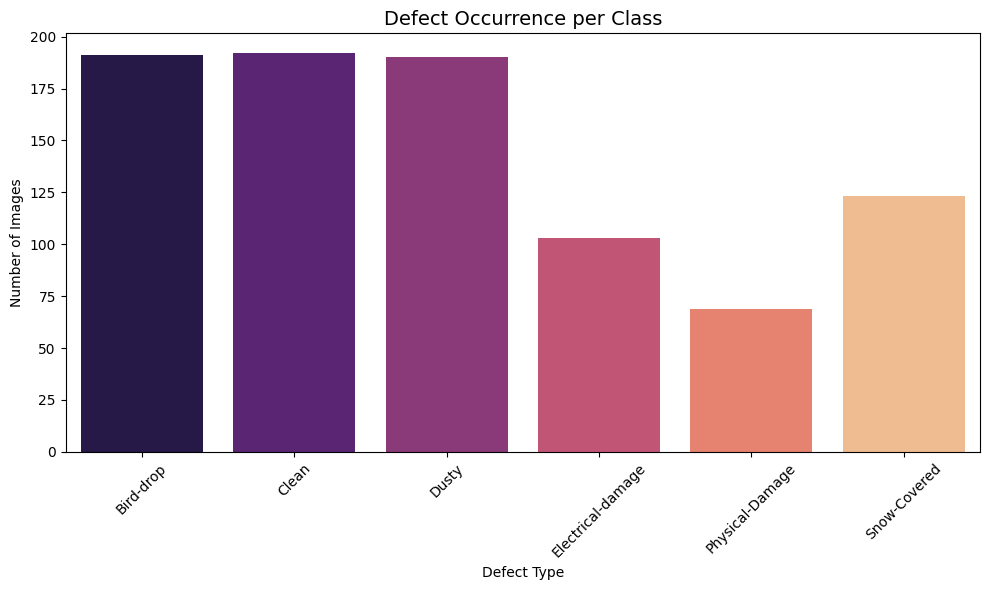

In [14]:
class_counts = Counter([dataset.classes[label] for _, label in dataset])

# 🎯 Display defect class frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="magma")
plt.title("Defect Occurrence per Class", fontsize=14)
plt.ylabel("Number of Images")
plt.xlabel("Defect Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Class Balance Insight

In [15]:
total = sum(class_counts.values())
for cls, count in class_counts.items():
    print(f"{cls:20}: {count} samples ({(count/total)*100:.2f}%)")

Bird-drop           : 191 samples (22.00%)
Clean               : 192 samples (22.12%)
Dusty               : 190 samples (21.89%)
Electrical-damage   : 103 samples (11.87%)
Physical-Damage     : 69 samples (7.95%)
Snow-Covered        : 123 samples (14.17%)


In [16]:
def draw_bounding_box(image_path, bbox):
    """
    Draw a bounding box on the image.
    bbox: (x, y, width, height)
    """
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imshow("Bounding Box Preview", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
# draw_bounding_box(r"path_to_image.jpg", bbox=(30, 40, 100, 80))


In [17]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\gowth\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129525 (\N{SPOOL OF THREAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


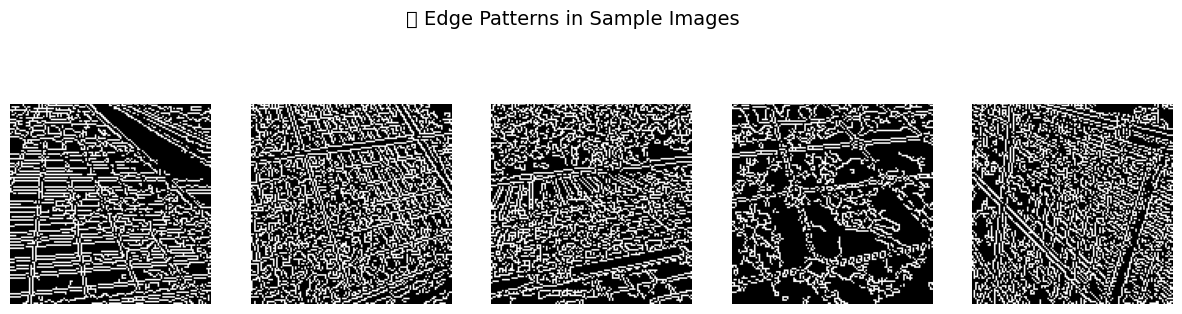

In [18]:
import cv2
def visualize_edges(dataset, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        img_tensor, _ = dataset[i]
        img = img_tensor.permute(1, 2, 0).numpy()
        img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(img_gray, threshold1=50, threshold2=150)
        axs[i].imshow(edges, cmap='gray')
        axs[i].axis('off')
    plt.suptitle("🧵 Edge Patterns in Sample Images", fontsize=14)
    plt.show()

visualize_edges(dataset)

C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


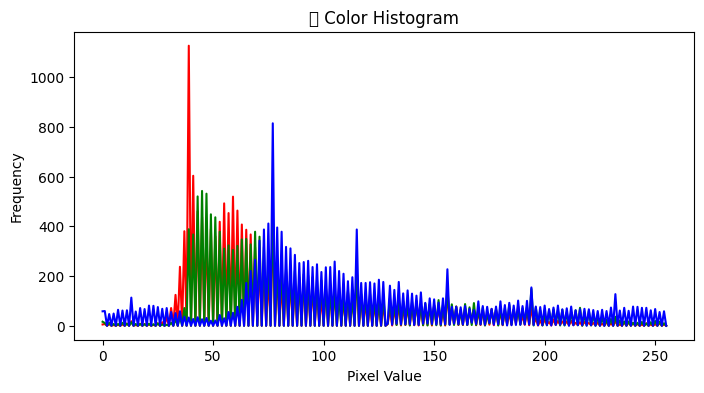

In [19]:
def show_color_histogram(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    color = ('r', 'g', 'b')
    plt.figure(figsize=(8, 4))
    for i, col in enumerate(color):
        hist = cv2.calcHist([(img * 255).astype(np.uint8)], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.title("🎨 Color Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

# Show histogram for one image
sample_img, _ = dataset[10]
show_color_histogram(sample_img)


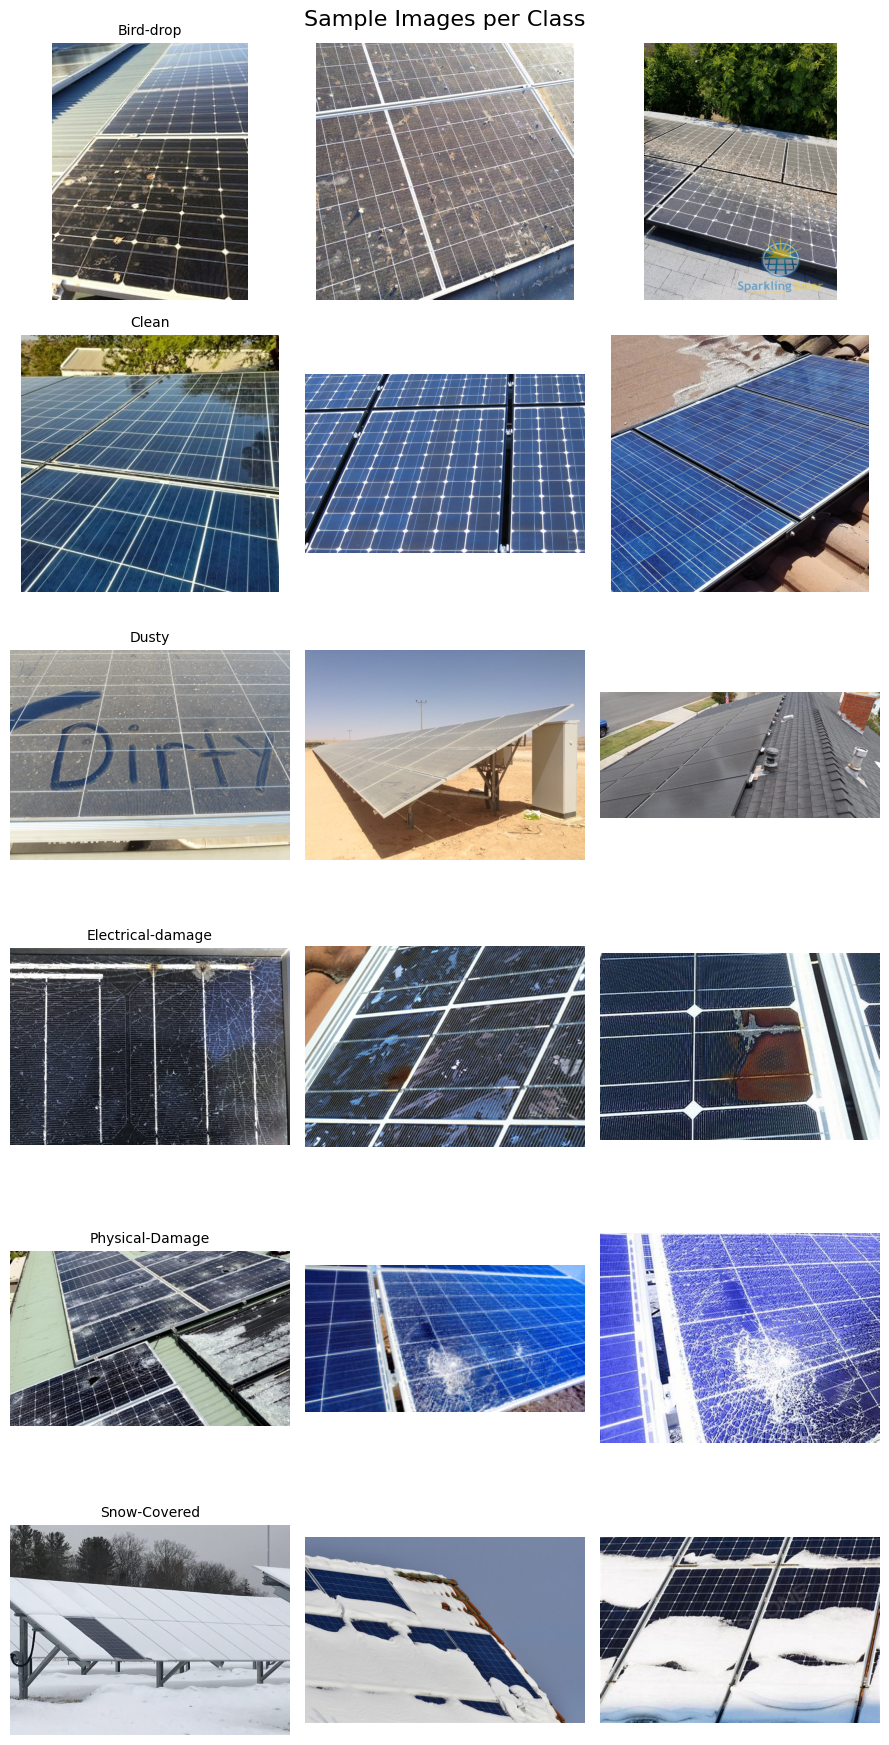

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_sample_images_per_class(dataset, classes, samples_per_class=3):
    fig, axs = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class*3, len(classes)*3))
    class_indices = {cls: [] for cls in classes}

    for img_path, label in dataset.samples:
        class_name = dataset.classes[label]
        if len(class_indices[class_name]) < samples_per_class:
            class_indices[class_name].append(img_path)

    for i, cls in enumerate(classes):
        for j, img_path in enumerate(class_indices[cls]):
            img = Image.open(img_path).convert("RGB")
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(cls, fontsize=10)
    plt.suptitle("Sample Images per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample_images_per_class(dataset, dataset.classes)


ResNet18 Model

In [21]:
resnet = models.resnet18(pretrained=True)

# Freeze early layers if desired
for param in resnet.parameters():
    param.requires_grad = False

# Replace classifier head
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(dataset.classes))
resnet = resnet.to(device)

C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
num_epochs = 10


In [23]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    resnet.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {accuracy:.2f}%")


Epoch 1/10 | Train Loss: 1.6877 | Val Loss: 1.4314 | Val Acc: 42.53%
Epoch 2/10 | Train Loss: 1.2558 | Val Loss: 1.2015 | Val Acc: 60.34%
Epoch 3/10 | Train Loss: 1.0055 | Val Loss: 1.0418 | Val Acc: 64.94%
Epoch 4/10 | Train Loss: 0.9099 | Val Loss: 0.9385 | Val Acc: 64.37%
Epoch 5/10 | Train Loss: 0.8527 | Val Loss: 0.8927 | Val Acc: 68.97%
Epoch 6/10 | Train Loss: 0.7907 | Val Loss: 0.9081 | Val Acc: 72.99%
Epoch 7/10 | Train Loss: 0.7475 | Val Loss: 0.9209 | Val Acc: 70.11%
Epoch 8/10 | Train Loss: 0.7065 | Val Loss: 0.8111 | Val Acc: 75.86%
Epoch 9/10 | Train Loss: 0.6118 | Val Loss: 0.7995 | Val Acc: 75.29%
Epoch 10/10 | Train Loss: 0.6204 | Val Loss: 0.7720 | Val Acc: 76.44%


In [24]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

resnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


📊 Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.75      0.57      0.65        42
            Clean       0.59      0.81      0.68        37
            Dusty       0.62      0.56      0.59        36
Electrical-damage       0.75      1.00      0.86        21
  Physical-Damage       0.78      0.50      0.61        14
     Snow-Covered       0.86      0.79      0.83        24

         accuracy                           0.70       174
        macro avg       0.73      0.70      0.70       174
     weighted avg       0.71      0.70      0.69       174



EfficientNet 

In [25]:
# Load pre-trained EfficientNet
model = models.efficientnet_b0(pretrained=True)

# Freeze base layers (optional)
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier head
num_classes = len(train_loader.dataset.dataset.classes)  # Total class count
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)


C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
from tqdm import tqdm
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"🔁 Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch 1/10: 100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


🔁 Epoch [1/10], Loss: 33.9536, Accuracy: 39.05%


Epoch 2/10: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


🔁 Epoch [2/10], Loss: 25.8113, Accuracy: 60.23%


Epoch 3/10: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


🔁 Epoch [3/10], Loss: 21.4909, Accuracy: 69.16%


Epoch 4/10: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it]


🔁 Epoch [4/10], Loss: 18.8553, Accuracy: 73.92%


Epoch 5/10: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


🔁 Epoch [5/10], Loss: 17.5957, Accuracy: 74.50%


Epoch 6/10: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


🔁 Epoch [6/10], Loss: 16.2502, Accuracy: 77.52%


Epoch 7/10: 100%|██████████| 22/22 [00:26<00:00,  1.19s/it]


🔁 Epoch [7/10], Loss: 14.9466, Accuracy: 78.53%


Epoch 8/10: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it]


🔁 Epoch [8/10], Loss: 14.4515, Accuracy: 78.96%


Epoch 9/10: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


🔁 Epoch [9/10], Loss: 14.0924, Accuracy: 78.24%


Epoch 10/10: 100%|██████████| 22/22 [00:25<00:00,  1.18s/it]

🔁 Epoch [10/10], Loss: 12.2485, Accuracy: 83.14%


In [29]:
from sklearn.metrics import classification_report

# Collect predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
class_names = val_loader.dataset.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("📊 EfficientNet Classification Report:\n")
print(report)


📊 EfficientNet Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.80      0.57      0.67        42
            Clean       0.63      0.73      0.68        37
            Dusty       0.62      0.64      0.63        36
Electrical-damage       0.86      0.90      0.88        21
  Physical-Damage       0.58      0.50      0.54        14
     Snow-Covered       0.67      0.83      0.74        24

         accuracy                           0.69       174
        macro avg       0.69      0.70      0.69       174
     weighted avg       0.70      0.69      0.69       174



MobileNetV2

In [30]:
# Load MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze feature extractor (optional for faster training)
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier head
num_classes = len(train_loader.dataset.dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)


C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [32]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"🔁 Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/10: 100%|██████████| 22/22 [00:26<00:00,  1.22s/it]


🔁 Epoch [1/10], Loss: 33.5288, Accuracy: 43.95%


Epoch 2/10: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


🔁 Epoch [2/10], Loss: 22.1649, Accuracy: 66.14%


Epoch 3/10: 100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


🔁 Epoch [3/10], Loss: 18.3841, Accuracy: 71.90%


Epoch 4/10: 100%|██████████| 22/22 [00:24<00:00,  1.09s/it]


🔁 Epoch [4/10], Loss: 16.3391, Accuracy: 74.93%


Epoch 5/10: 100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


🔁 Epoch [5/10], Loss: 14.0837, Accuracy: 79.68%


Epoch 6/10: 100%|██████████| 22/22 [00:23<00:00,  1.09s/it]


🔁 Epoch [6/10], Loss: 14.1891, Accuracy: 77.81%


Epoch 7/10: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


🔁 Epoch [7/10], Loss: 13.2097, Accuracy: 79.39%


Epoch 8/10: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]


🔁 Epoch [8/10], Loss: 11.6027, Accuracy: 81.84%


Epoch 9/10: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]


🔁 Epoch [9/10], Loss: 12.5182, Accuracy: 80.98%


Epoch 10/10: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]

🔁 Epoch [10/10], Loss: 10.8175, Accuracy: 83.86%


In [33]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
class_names = val_loader.dataset.dataset.classes
print("📊 MobileNetV2 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


📊 MobileNetV2 Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.76      0.69      0.72        42
            Clean       0.73      0.81      0.77        37
            Dusty       0.78      0.69      0.74        36
Electrical-damage       0.86      0.90      0.88        21
  Physical-Damage       0.71      0.71      0.71        14
     Snow-Covered       0.81      0.92      0.86        24

         accuracy                           0.78       174
        macro avg       0.78      0.79      0.78       174
     weighted avg       0.78      0.78      0.77       174



Again preprocessing

In [36]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [38]:
from torchvision import datasets, transforms, models

In [39]:
data_dir = r"D:\GOWTHAM\DATA SCIENCE\solar panel DL" 
dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)

In [40]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = transform_val

In [44]:
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler

In [45]:
targets = [dataset[i][1] for i in train_ds.indices]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
weights = [class_weights[label] for label in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=16)

In [46]:
model = models.mobilenet_v2(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = True

num_classes = len(dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)

C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [49]:
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)
for epoch in range(15):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    scheduler.step()
    print(f"Epoch {epoch+1}/15 - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/15 - Train Acc: 0.7061, Val Acc: 0.7069
Epoch 2/15 - Train Acc: 0.8862, Val Acc: 0.7701
Epoch 3/15 - Train Acc: 0.8775, Val Acc: 0.7241
Epoch 4/15 - Train Acc: 0.9265, Val Acc: 0.8161
Epoch 5/15 - Train Acc: 0.9409, Val Acc: 0.8448
Epoch 6/15 - Train Acc: 0.9683, Val Acc: 0.8506
Epoch 7/15 - Train Acc: 0.9769, Val Acc: 0.8506
Epoch 8/15 - Train Acc: 0.9726, Val Acc: 0.8621
Epoch 9/15 - Train Acc: 0.9827, Val Acc: 0.8563
Epoch 10/15 - Train Acc: 0.9870, Val Acc: 0.8736
Epoch 11/15 - Train Acc: 0.9841, Val Acc: 0.8506
Epoch 12/15 - Train Acc: 0.9841, Val Acc: 0.8448
Epoch 13/15 - Train Acc: 0.9784, Val Acc: 0.8506
Epoch 14/15 - Train Acc: 0.9755, Val Acc: 0.8678
Epoch 15/15 - Train Acc: 0.9841, Val Acc: 0.8736


📊 Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.87      0.94      0.90        35
            Clean       0.88      0.80      0.84        45
            Dusty       0.76      0.82      0.78        38
Electrical-damage       1.00      0.95      0.98        22
  Physical-Damage       0.92      0.85      0.88        13
     Snow-Covered       0.95      0.95      0.95        21

         accuracy                           0.87       174
        macro avg       0.90      0.89      0.89       174
     weighted avg       0.88      0.87      0.87       174



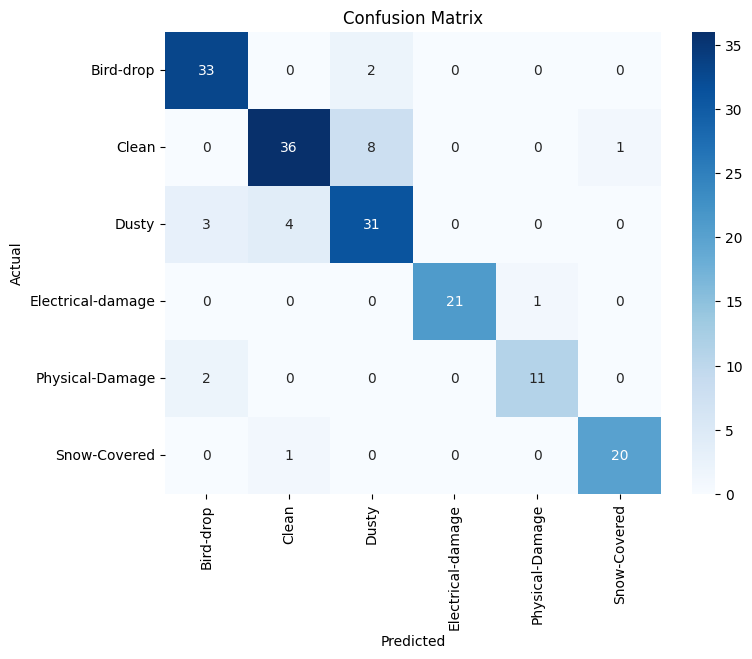

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Evaluate model on validation data
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Step 2: Classification report
class_names = dataset.classes  
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("📊 Classification Report:\n")
print(report)

# Step 3: Confusion matrix (visual)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [51]:
import torch

# Example: Save MobileNetV2 model
torch.save(model.state_dict(), 'mobilenet_model.pth')
